In [1]:
import pandas as pd
import re
import numpy as np
import gensim
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# spacy for lemmatization
# import spacy
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from IPython.display import clear_output
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# Import the wordcloud library
from wordcloud import WordCloud

lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [3]:
# for plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

### Loading data

In [4]:
import os
pwd = os.getcwd()

In [5]:
emails = pd.read_csv(os.path.basename(pwd +'/emails.csv'))

In [6]:
emails.count()

file       517401
message    517401
dtype: int64

In [7]:
# email_subset = emails.sample(frac=0.05, random_state=1)
email_subset = emails[1000:3000]
print(email_subset.shape)
print(email_subset.head())

(2000, 2)
                            file  \
1000  allen-p/all_documents/462.   
1001  allen-p/all_documents/463.   
1002  allen-p/all_documents/464.   
1003  allen-p/all_documents/465.   
1004  allen-p/all_documents/466.   

                                                message  
1000  Message-ID: <1081797.1075855696183.JavaMail.ev...  
1001  Message-ID: <28830232.1075855696211.JavaMail.e...  
1002  Message-ID: <23711632.1075855696233.JavaMail.e...  
1003  Message-ID: <28968716.1075855696255.JavaMail.e...  
1004  Message-ID: <2413536.1075855696276.JavaMail.ev...  


### Data Cleaning
- We have to do topic modelling on text data, I have removed redundant imformation and kept only: email body , From and To.
- I am only using 5000 emails

In [8]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to', 'date']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [9]:
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'),
        'to': map_to_list(emails, 'to'),
        'from_': map_to_list(emails, 'from'),
        'date': map_to_list(emails, 'date'),
        'TC': 0,
        'SN': 0,
        'KS': 0,
        'OT': 0,
        'print': np.nan
    }

In [10]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
email_df = pd.DataFrame(parse_into_emails(email_subset.message))

In [13]:
# To check there are no empty columns
email_df.drop(email_df.query(
    "body == '' | to == '' | from_ == '' | date == ''"
).index, inplace=True)
email_df.head()

,body,to,from_,date,TC,SN,KS,OT,print
0,"Lucy,Here is the rentroll.My only questions ar...",stagecoachmama@hotmail.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 07",0,0,0,0,NaN
1,I also need to know the base salaries of Jay R...,todd.burke@enron.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 06",0,0,0,0,NaN
2,---------------------- Forwarded by Phillip K ...,Western.Price.Survey.contacts@ren-10.cais.net,phillip.allen@enron.com,"Thu, 15 Mar 2001 06",0,0,0,0,NaN
3,Thanks for the information. It would be helpf...,kim.bolton@enron.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 06",0,0,0,0,NaN
4,---------------------- Forwarded by Phillip K ...,Phillip.K.Allen@enron.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 04",0,0,0,0,NaN


In [14]:
email_df.count()

body     1888
to       1888
from_    1888
date     1888
TC       1888
SN       1888
KS       1888
OT       1888
print       0
dtype: int64

In [15]:
email_df['date'] = email_df['date'].str[4:16]
email_df['body'][1]

'I also need to know the base salaries of Jay Reitmeyer and Monique Sanchez.They are doing the same job as Matt.'

### Remove punctuation/lower casing
- Preprocessing on the content to make it more amenable for analysis

In [16]:
# Remove punctuation
email_df['text_processed'] = \
email_df['text_processed'] = email_df['body'].str.replace(r'[^\w\s]','')
# Convert the textto lowercase
email_df['text_processed'] = \
email_df['text_processed'].map(lambda x: x.lower())


In [17]:
email_df['text_processed'] = email_df['text_processed'].map(lambda com : clean_text(com))

In [18]:
email_df['text_processed'][1]

'i also need to know the base salaries of jay reitmeyer and monique sanchezthey are doing the same job as matt'

### Exploratory Analysis
Wordcloud package to get a visual representation of most common words

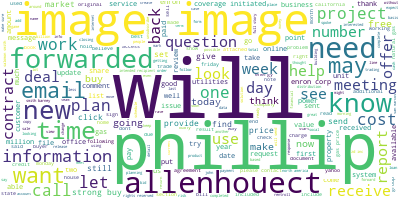

In [19]:
# Join the different processed titles together.
long_string = ','.join(list(email_df['text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()


### LDA Analysis : Transform data in a format that will serve as an input for training LDA model

In [20]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Analyzing text with TF-IDF

In [21]:

# # vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
# ## Tokenize the sentences
# max_features = 120000 
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(train_X)+list(test_X))
# train_X = tokenizer.texts_to_sequences(train_X)
# test_X = tokenizer.texts_to_sequences(test_X)
# # X = vect.fit_transform(email_df.text_processed)

In [22]:
email_df.to_pickle('email.pickle')


In [23]:
# # def manually_label(email_file):
    
# df = pd.read_pickle('email.pickle')
# for index, row in df.iterrows():
#         print('Is this sentence? Type 1 if team communication,',
#               '\nType 2: social networking,','\nType 3:  knowledge sharing and ',
#               '\nType 4: others . \n')
#         print(row.text_processed)
#         label = input()
#         print(label)
#         if '1' in label:
#             df.loc[index, 'TC'] = 1
#         if '2' in label:
#             df.loc[index, 'SN'] = 1
#         if '3' in label:
#             df.loc[index, 'KS'] = 1
#         if '4' in label:
#             df.loc[index, 'OT'] = 1
#         if label == '':
#             df.loc[index, 'OT'] = 1
#         clear_output()
        
#         df.to_pickle('email.pickle')
        
# print('No more labels to classify!')
    


In [ ]:
# df.to_csv(os.path.basename(pwd +'/final_result1.csv'))

In [159]:
df = pd.read_csv(os.path.basename(pwd +'/final_train.csv'))

In [26]:
df.head(3)

,body,to,from,date,TC,SN,KS,OT,text_processed
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com,14-May-2001,1,0,0,0,here is our forecast
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com,4-May-2001,0,1,0,0,traveling to have a business meeting takes the...
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com,18-Oct-2000,1,0,0,0,test successful way to go


In [27]:
categories = ['TC','SN','KS','OT']

In [28]:
counts = []
for i in categories:
    counts.append((i, df[i].sum()))

In [29]:
df_stats = pd.DataFrame(counts, columns=['category','number_of_comments'])
df_stats

,category,number_of_comments
0,TC,643
1,SN,240
2,KS,143
3,OT,77


Text(0.5, 0, 'category')

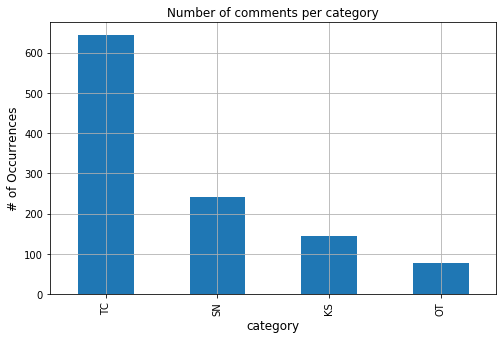

In [30]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

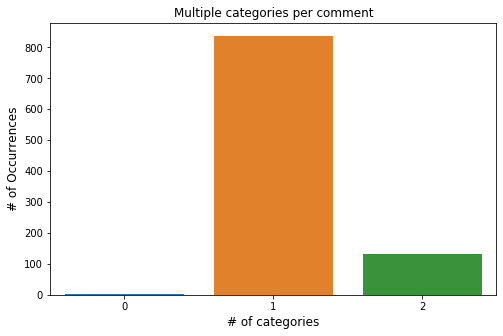

In [31]:
import seaborn as sns
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [32]:
df.dtypes

body              object
to                object
from              object
date              object
TC                 int64
SN                 int64
KS                 int64
OT                 int64
text_processed    object
dtype: object

In [33]:
from sklearn.model_selection import train_test_split
categories = ['TC', 'SN', 'KS', 'OT']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

X_train = train.text_processed
X_test = test.text_processed
print(X_train.shape)
print(X_test.shape)

(650,)
(321,)


In [34]:
X_train.head()

922    forwarded by phillip k allenhouect on 04102001...
90     open the utility spreadsheet and try to comple...
911    jeffi am in the office today any isssues to de...
181    forwarded by phillip k allenhouect on 04282000...
274    forwarded by phillip k allenhouect on 05072001...
Name: text_processed, dtype: object

In [35]:
stop_words = stopwords.words('english')# replace with space
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [36]:
# ## Tokenize the sentences
# max_features = 120000 
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X_train)+list(X_test))
# xtrain = tokenizer.texts_to_sequences(X_train)
# xtest = tokenizer.texts_to_sequences(X_test)


### Pad Sequence: Normally model expects that each text sequence  will be of the same length 

In [38]:
# maxlen = 750 # max number of words in a question to use
# train = pad_sequences(xtrain, maxlen=maxlen)
# test = pad_sequences(xtest, maxlen=maxlen)

In [41]:
df_result = pd.DataFrame(columns=('Type',  'Model', 'Accuray','Precision',
                                   'Recall','Fmeasure'))

### Naive Bayes

In [42]:
# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [43]:
result=[]
count = 0
# df_result.set_index('Type')
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    result = {'Type' :category,
              'Model' : 'NB',
             ('Accuray' ):  accuracy_score(test[category], prediction),
             ('Precision' ) :precision_score(test[category], prediction),
             ('Recall') :recall_score(test[category], prediction),
             ('Fmeasure') :f1_score(test[category], prediction)}
    
    row_to_add = pd.Series(result, name='x')
    df_result = df_result.append(result ,ignore_index=True)

    

... Processing TC
... Processing SN
... Processing KS
... Processing OT


C:\Users\shrad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Linear SVC

In [44]:
from sklearn.svm import LinearSVC
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])


In [45]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    result = {'Type' :category,
              'Model' : 'SVC',
             ('Accuray' ):  accuracy_score(test[category], prediction),
             ('Precision' ) :precision_score(test[category], prediction),
             ('Recall') :recall_score(test[category], prediction),
             ('Fmeasure') :f1_score(test[category], prediction)}
    
    row_to_add = pd.Series(result, name='x')
    df_result = df_result.append(result ,ignore_index=True)

... Processing TC
... Processing SN
... Processing KS
... Processing OT


### Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])


In [47]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    result = {'Type' :category,
              'Model' : 'LR',
             ('Accuray' ):  accuracy_score(test[category], prediction),
             ('Precision' ) :precision_score(test[category], prediction),
             ('Recall') :recall_score(test[category], prediction),
             ('Fmeasure') :f1_score(test[category], prediction)}
    
    row_to_add = pd.Series(result, name='x')
    df_result = df_result.append(result ,ignore_index=True)

... Processing TC
... Processing SN
... Processing KS
... Processing OT


### Artificial Neural Network

In [48]:
from tensorflow import keras
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(10,activation="softmax"))

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

### Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
from sklearn.linear_model import LogisticRegression
RF_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(RandomForestClassifier())),
            ])

In [53]:
for category in categories:
    print('... Processing {}'.format(category))

    RF_pipeline.fit(X_train, train[category])

    prediction = RF_pipeline.predict(X_test)
    result = {'Type' :category,
              'Model' : 'RF',
             ('Accuray' ):  accuracy_score(test[category], prediction),
             ('Precision' ) :precision_score(test[category], prediction),
             ('Recall') :recall_score(test[category], prediction),
             ('Fmeasure') :f1_score(test[category], prediction)}
    
    row_to_add = pd.Series(result, name='x')
    df_result = df_result.append(result ,ignore_index=True)

... Processing TC
... Processing SN
... Processing KS
... Processing OT


### Deep Learning :Pytorch Model - TextCNN

In [54]:
import torch.nn as nn
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.optim.optimizer import Optimizer

embed_size = 300 # how big is each word vector

In [55]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
#         n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
#         self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [104]:
# n_epochs = 6
# model = CNN_Text()
# loss_fn = nn.CrossEntropyLoss(reduction='sum')

### SVM

In [65]:
from sklearn.svm import SVC
SVM_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', SVC()),
            ])

In [66]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVM_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVM_pipeline.predict(X_test)
    result = {'Type' :category,
              'Model' : 'SVM',
             ('Accuray' ):  accuracy_score(test[category], prediction),
             ('Precision' ) :precision_score(test[category], prediction),
             ('Recall') :recall_score(test[category], prediction),
             ('Fmeasure') :f1_score(test[category], prediction)}
    
    row_to_add = pd.Series(result, name='x')
    df_result = df_result.append(result ,ignore_index=True)

... Processing TC
... Processing SN
... Processing KS
... Processing OT


#### Linear SVC  performed better as compared to other models

In [ ]:
email_df.head()

In [57]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(email_df['text_processed'])
    email_df[category] = prediction

... Processing TC
... Processing SN
... Processing KS
... Processing OT


In [67]:
df_result

,Type,Model,Accuray,Precision,Recall,Fmeasure
0,TC,NB,0.700935,0.689189,0.980769,0.809524
1,SN,NB,0.753894,1.000000,0.012500,0.024691
2,KS,NB,0.869159,0.833333,0.108696,0.192308
3,OT,NB,0.912773,0.000000,0.000000,0.000000
4,TC,SVC,0.725857,0.729008,0.918269,0.812766
5,SN,SVC,0.775701,0.590909,0.325000,0.419355
6,KS,SVC,0.872274,0.586207,0.369565,0.453333
7,OT,SVC,0.925234,0.700000,0.250000,0.368421
8,TC,LR,0.707165,0.688742,1.000000,0.815686
9,SN,LR,0.760125,1.000000,0.037500,0.072289


In [160]:
df["Month"] = list(map(lambda x: datetime.strptime(x,'%d-%b-%Y').strftime('%B'), df['date']))
df["Year"] = list(map(lambda x: datetime.strptime(x,'%d-%b-%Y').strftime('%Y'), df['date']))
df.head()

,body,to,from,date,TC,SN,KS,OT,text_processed,Month,Year
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com,14-May-2001,1,0,0,0,here is our forecast,May,2001
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com,4-May-2001,0,1,0,0,traveling to have a business meeting takes the...,May,2001
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com,18-Oct-2000,1,0,0,0,test successful way to go,October,2000
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com,23-Oct-2000,1,0,0,0,randycan you send me a schedule of the salary ...,October,2000
4,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com,31-Aug-2000,0,1,0,0,greghow about either next tuesday or thursdayp...,August,2000


In [161]:
df.drop(['body', 'to', 'date'], axis=1, inplace=True)

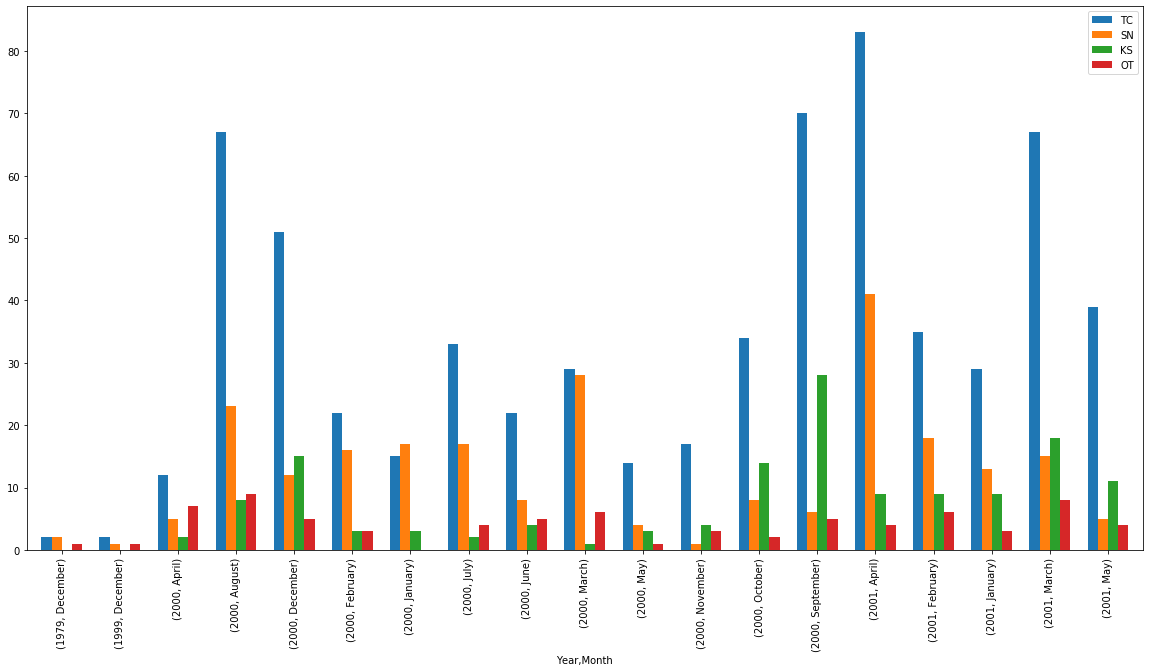

In [162]:
df.groupby(['Year','Month']).sum().plot(kind="bar",figsize=(20,10), width = 0.7)


In [163]:
df['from'] = df['from'].str.split('@').str[0]
df['from'] = df['from'].str.replace('\d+', '')


<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<ipython-input-163-9109712eda1f>:2: DeprecationWarning: invalid escape sequence \d
  df['from'] = df['from'].str.replace('\d+', '')


In [165]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['from'] = df['from'].str.replace(char, ' ')

In [166]:
df['from'].value_counts()

phillip allen               884
critical notice               5
Phillip K Allen               5
Leslie Lawner                 4
ina rangel                    4
Phillip K Allen  mailto       4
Sarah Novosel                 3
Frank Hayden ENRON            3
Allen  Phillip                3
sarah novosel                 2
webmaster                     2
Kristin Walsh ENRON           2
announce                      2
Andy Chen on                  2
ei editor                     2
pallen                        2
jsmith                        2
Steven J Kean                 2
James D Steffes               2
Mark Whitt                    2
aod                           2
lisa jacobson                 1
paul kaufman                  1
Jeff Dasovich on              1
grensheltr                    1
gthorse                       1
subscriptions                 1
Hayden  Frank                 1
 Kristin Walsh ENRON          1
tracy arthur                  1
perfmgmt                      1
yild    

In [222]:
df_sum   = pd.pivot_table(df, index=['from','Year','Month'],values=['TC','SN','KS','OT'],aggfunc=np.sum).reset_index()
df_count = df.groupby(['from','Year','Month'])["from"].count().reset_index(name="count")

In [223]:
df_text = df.groupby(['from','Year','Month'])['text_processed'].apply(lambda x: ','.join(x)).reset_index()

In [228]:
df_final = pd.concat([df_sum,df_count['count'],df_text['text_processed']],axis=1)

In [227]:
df_final = df_final.reindex(columns = ['from', 'Month', 'Year','text_processed','count',
                  'SN', 'KS', 'TC', 'OT'] )
df_final.head()

,from,Month,Year,text_processed,count,SN,KS,TC,OT
0,,December,2000,americain todays daily update youll find free ...,1,0,1,1,0
1,Kristin Walsh ENRON,May,2001,forwarded by phillip k allenhouect on 05072001...,1,0,1,1,0
2,Wesko George gwesko,January,2000,4dde116dbca1d3118b130080c840baad02cd53ppimsser...,1,0,0,1,0
3,Allen Phillip,April,2001,inacan you please forward the presentation to ...,3,1,0,2,0
4,Andy Chen on,July,2000,forwarded by phillip k allenhouect on 07132000...,2,0,0,2,0


### Calculate Negative and Positive Sentiment

In [247]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from textblob import TextBlob

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [245]:
#load the descriptions into textblob
desc_blob = [TextBlob(desc) for desc in df_final['text_processed']]
#add the sentiment metrics to the dataframe
df_final['tb_Pol'] = [b.sentiment.polarity for b in desc_blob]
df_final['tb_Subj'] = [b.sentiment.subjectivity for b in desc_blob]
#show dataframe
df_final.head(3)

,from,Year,Month,KS,OT,SN,TC,count,text_processed,tb_Pol,tb_Subj
0,,2000,December,1,0,0,1,1,americain todays daily update youll find free ...,0.203955,0.483789
1,Kristin Walsh ENRON,2001,May,1,0,0,1,1,forwarded by phillip k allenhouect on 05072001...,0.034821,0.533532
2,Wesko George gwesko,2000,January,0,0,0,1,1,4dde116dbca1d3118b130080c840baad02cd53ppimsser...,0.566667,0.566667


In [248]:
#load VADER
analyzer = SentimentIntensityAnalyzer()
#Add VADER metrics to dataframe
df_final['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df_final['text_processed']]
df_final['negative'] = [analyzer.polarity_scores(v)['neg'] for v in df_final['text_processed']]
df_final['neutral']  = [analyzer.polarity_scores(v)['neu'] for v in df_final['text_processed']]
df_final['positive'] = [analyzer.polarity_scores(v)['pos'] for v in df_final['text_processed']]
df_final.head(3)

,from,Year,Month,KS,OT,SN,TC,count,text_processed,tb_Pol,tb_Subj,compound,negative,neutral,positive
0,,2000,December,1,0,0,1,1,americain todays daily update youll find free ...,0.203955,0.483789,0.9982,0.009,0.851,0.141
1,Kristin Walsh ENRON,2001,May,1,0,0,1,1,forwarded by phillip k allenhouect on 05072001...,0.034821,0.533532,-0.5937,0.044,0.920,0.035
2,Wesko George gwesko,2000,January,0,0,0,1,1,4dde116dbca1d3118b130080c840baad02cd53ppimsser...,0.566667,0.566667,0.8834,0.000,0.760,0.240


In [58]:
email_df.head()

,body,to,from_,date,TC,SN,KS,OT,print,text_processed
0,"Lucy,Here is the rentroll.My only questions ar...",stagecoachmama@hotmail.com,phillip.allen@enron.com,15 Mar 2001,0,1,0,0,NaN,lucyhere is the rentrollmy only questions are ...
1,I also need to know the base salaries of Jay R...,todd.burke@enron.com,phillip.allen@enron.com,15 Mar 2001,0,1,0,0,NaN,i also need to know the base salaries of jay r...
2,---------------------- Forwarded by Phillip K ...,Western.Price.Survey.contacts@ren-10.cais.net,phillip.allen@enron.com,15 Mar 2001,1,0,0,0,NaN,forwarded by phillip k allenhouect on 03152001...
3,Thanks for the information. It would be helpf...,kim.bolton@enron.com,phillip.allen@enron.com,15 Mar 2001,1,0,0,0,NaN,thanks for the information it would be helpful...
4,---------------------- Forwarded by Phillip K ...,Phillip.K.Allen@enron.com,phillip.allen@enron.com,15 Mar 2001,1,0,0,0,NaN,forwarded by phillip k allenhouect on 03152001...


In [59]:
df.to_csv(os.path.basename(pwd +'/final_test.csv'))

In [60]:
print(email_df.iloc[1]['text_processed'])

i also need to know the base salaries of jay reitmeyer and monique sanchezthey are doing the same job as matt


In [61]:
data = email_df.text_processed.values.tolist()

In [62]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        texts_out.append([lemmatizer.lemmatize(i) for i in sent])
    return texts_out

In [63]:
data_words = list(sent_to_words(data))

In [64]:
print(data_words[1])

['also', 'need', 'to', 'know', 'the', 'base', 'salaries', 'of', 'jay', 'reitmeyer', 'and', 'monique', 'sanchezthey', 'are', 'doing', 'the', 'same', 'job', 'as', 'matt']


In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [ ]:
# data_lemmatized = lemmatization(data_words_bigrams)
data_lemmatized = lemmatization(data_words_nostops)

In [ ]:
print(data_lemmatized[1])

### Bag of Words on the Data set

In [ ]:
import gensim.corpora as corpora# Create Dictionary
dictionary = corpora.Dictionary(data_lemmatized)# Create Corpus

In [ ]:
print('Number of unique words in initital documents:', len(dictionary))

In [ ]:
# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print('Number of unique words after removing rare and common words:', len(dictionary))

In [ ]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

### Gensim doc2bow

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data_lemmatized]
bow_corpus[489]

In [ ]:
bow_doc_489 = bow_corpus[489]
for i in range(len(bow_doc_489)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_489[i][0], 
                                               dictionary[bow_doc_489[i][0]], 
bow_doc_489[i][1]))

### TF-IDF

In [ ]:
from gensim import corpora, models
from pprint import pprint

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    if doc != []:
        pprint(doc)
        break

### LDA using Bag of Words

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=10, 
                                       id2word=dictionary,
                                       passes=2, workers=2)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

### Running LDA using TF-IDF

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10,
                                             id2word=dictionary,
                                             passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

In [ ]:
for index, score in sorted(lda_model[bow_corpus[489]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[489]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))